# Pathway Level Difference Analysis using Cohen's $d$ and KS test.

This notebook identifies **which pathways are significantly altered by disease conditions** across the **two homological dimensions**: That is, dimension 0 (connected components) and dimension 1 (cycles).

Significance is determined for each pathway using two complementary measures:
- **Cohen’s $d$** — quantifies the effect size between control and disease distributions (Betti series).
- **Kolmogorov–Smirnov (KS) test** — evaluates whether the two distributions (control and disease Betti series) differ significantly.

A pathway is considered significantly altered if the **adjusted p-values (Benjamini–Hochberg correction, FDR < 0.05)** indicate significance in **both dimensions** and for **both statistical measures**.

In [ ]:
import pandas as pd                  # For data handling and manipulation
import numpy as np                   # Numerical computations, array and matrix handling
import pickle                        # Load saved persistence diagrams and intermediate data
from sklearn.preprocessing import StandardScaler # For normalizing gene expression data
from sklearn.decomposition import PCA             # For dimensionality reduction and visualization
from sklearn.metrics import silhouette_score  # To evaluate clustering quality by measuring how well each point fits within its cluster
from statsmodels.stats.multitest import multipletests  # Multiple testing correction (e.g., Benjamini–Hochberg)
import gseapy as gp                              # For running Gene Set Enrichment Analysis (GSEA)
from gseapy import dotplot           # Used to visualize enrichment results from GSEA analysis as dot plots
import matplotlib.pyplot as plt      # Visualization of persistence landscapes and results
from upsetplot import from_contents  # To create an input data structure from sets/lists for UpSet plots
from upsetplot import UpSet          # To generate UpSet plots, which visualize intersections among multiple sets
from matplotlib_venn import venn2  # For creating 2-set Venn diagrams to show overlaps between pathway groups
from utils import plot_betti_numbers
from run_analysis import pathway_level_difference_analysis # Load pathway level analyss function


In [93]:
df_tpm_rna_log2 = pd.read_csv('PBMC_RNASeq_PRNA739257_log2TPM_symbol.csv', header=0)#, index_col = 0)
df_tpm_rna_log2 = df_tpm_rna_log2.rename(columns={'Unnamed: 0': 'Symbol'})
df_tpm_rna_log2 = df_tpm_rna_log2.set_index('Symbol')
df_all = df_tpm_rna_log2
class_length = 17
df_control = df_all.iloc[:, :class_length]
df_disease = df_all.iloc[:, class_length:]

In [94]:
kegg_filt = pd.read_csv('kegg_pathways_info_clean_data_symbol.csv')
kegg_map = pd.read_csv('Genes_Map_KEGG_pathways.txt', delimiter='\t')

In [95]:
# Load dictionaries
with open('Adjacency Matrices/select_kegg_pathways_adjacency_matrices.pkl', 'rb') as f:
    adjacency_matrices = pickle.load(f)
    
with open('Pathways Expressions/select_kegg_pathways_expression_data.pkl', 'rb') as f:
    kegg_pathways_expressions = pickle.load(f)

In [96]:
# Load the Betti numbers series obtained from PPH computation.
# The file contains a dictionary structured as:
# {dimension (0 or 1) → pathway ID (KEGG hsa codes) → condition ('control' or 'disease') → Betti series}
with open('Results/betti_numbers_absolute_correlation_dict.pkl', 'rb') as f:
    betti_numbers_dict = pickle.load(f)

In [97]:
# Extract Betti series per dimension
dim0_betti_numbers_dict = betti_numbers_dict['0']
dim1_betti_numbers_dict = betti_numbers_dict['1']

In [98]:
# List of IDs of pathways (KEGG hsa codes for GenPath-PPH) to be analyzed
path_ids = ['hsa00230', 'hsa00380', 'hsa04141', 'hsa04010', 'hsa04014', 
                   'hsa04015', 'hsa04310', 'hsa04350', 'hsa04630', 'hsa04150', 
                   'hsa04110', 'hsa04216', 'hsa04115', 'hsa04660', 'hsa04657',
                   'hsa02010', 'hsa04012', 'hsa04330', 'hsa04340', 'hsa04390',
                   'hsa04370', 'hsa04371', 'hsa04064', 'hsa04066', 'hsa04668', 
                   'hsa04068', 'hsa04020', 'hsa04070', 'hsa04072', 'hsa04071', 
                   'hsa04022', 'hsa04024', 'hsa04151', 'hsa04152', 'hsa04080', 
                   'hsa04060', 'hsa04061', 'hsa04512', 'hsa04514', 'hsa04710',
                   'hsa00970', 'hsa03008', 'hsa03010', 'hsa03040', 'hsa03013', 
                   'hsa03015', 'hsa03020', 'hsa03060', 'hsa03022', 'hsa04130',
                   'hsa03018', 'hsa03030', 'hsa03050', 'hsa03082', 'hsa03083', 
                   'hsa03250', 'hsa03260', 'hsa03264', 'hsa03265', 'hsa03266',
                   'hsa04122', 'hsa03267', 'hsa03410', 'hsa03420', 'hsa04750', 
                   'hsa04713', 'hsa04714', 'hsa04211', 'hsa04360', 'hsa04380', 
                   'hsa04744', 'hsa04740', 'hsa04742', 'hsa03430', 'hsa03440', 
                   'hsa03450', 'hsa03460', 'hsa04120', 'hsa04720', 'hsa04721', 
                   'hsa04722', 'hsa04723', 'hsa04724', 'hsa04725', 'hsa04726', 
                   'hsa04727', 'hsa04728', 'hsa04730', 'hsa04962', 'hsa04960',
                   'hsa04260', 'hsa04261', 'hsa04270', 'hsa04970', 'hsa04971',
                   'hsa04972', 'hsa04973', 'hsa04974', 'hsa04975', 'hsa04976',
                   'hsa04977', 'hsa04978', 'hsa04979', 'hsa04964', 'hsa04966',
                   'hsa03320', 'hsa04614', 'hsa04910', 'hsa04911', 'hsa04912',
                   'hsa04913', 'hsa04914', 'hsa04915', 'hsa04916', 'hsa04917',
                   'hsa04918', 'hsa04919', 'hsa04920', 'hsa04921', 'hsa04922',
                   'hsa04923', 'hsa04924', 'hsa04925', 'hsa04926', 'hsa04927',
                   'hsa04928', 'hsa04929', 'hsa04935', 'hsa04961', 'hsa04664',
                   'hsa04062', 'hsa04610', 'hsa04611', 'hsa04612', 'hsa04613',
                   'hsa04620', 'hsa04621', 'hsa04622', 'hsa04623', 'hsa04625',
                   'hsa04640', 'hsa04650', 'hsa04658', 'hsa04659', 'hsa04662',
                   'hsa04670', 'hsa04666', 'hsa04672', 'hsa00640', 'hsa00650',
                   'hsa00010', 'hsa00020', 'hsa00030', 'hsa00040', 'hsa00051',
                   'hsa00052', 'hsa00053', 'hsa00500', 'hsa00520', 'hsa00562',
                   'hsa00620', 'hsa00630', 'hsa00910', 'hsa00920', 'hsa01040',
                   'hsa00061', 'hsa00062', 'hsa00071', 'hsa00100', 'hsa00120',
                   'hsa00140', 'hsa00190', 'hsa00240', 'hsa00561', 'hsa00564',
                   'hsa00565', 'hsa00590', 'hsa00591', 'hsa00592', 'hsa00600',
                   'hsa00220', 'hsa00250', 'hsa00260', 'hsa00270', 'hsa00280',
                   'hsa00290', 'hsa00310', 'hsa00330', 'hsa00340', 'hsa00350',
                   'hsa00360', 'hsa00400', 'hsa00410', 'hsa00430', 'hsa00440',
                   'hsa00450', 'hsa00470', 'hsa00480', 'hsa00750', 'hsa00760',
                   'hsa00130', 'hsa00510', 'hsa00511', 'hsa00512', 'hsa00513',
                   'hsa00514', 'hsa00515', 'hsa00531', 'hsa00532', 'hsa00533',
                   'hsa00534', 'hsa00780', 'hsa00830', 'hsa00563', 'hsa00601',
                   'hsa00603', 'hsa00604', 'hsa00670', 'hsa00785', 'hsa00860',
                   'hsa00730', 'hsa00740', 'hsa00770', 'hsa00790', 'hsa00983',
                   'hsa00232', 'hsa00524', 'hsa00900', 'hsa00980', 'hsa00982',
                   'hsa04114', 'hsa04136', 'hsa04137', 'hsa04140', 'hsa04142',
                   'hsa04144', 'hsa04145', 'hsa04146', 'hsa04210', 'hsa04213',
                   'hsa04215', 'hsa04217', 'hsa04218', 'hsa04392', 'hsa04510',
                   'hsa04520', 'hsa04530', 'hsa04540', 'hsa04550', 'hsa04810',
                   'hsa04814']

### Visualizations - Betti Number Plot
This plot display the number of topological features (Betti numbers) across filtration values for each dimension. They provide a visual summary of how connected components, loops, and higher-dimensional structures evolve through the filtration process.

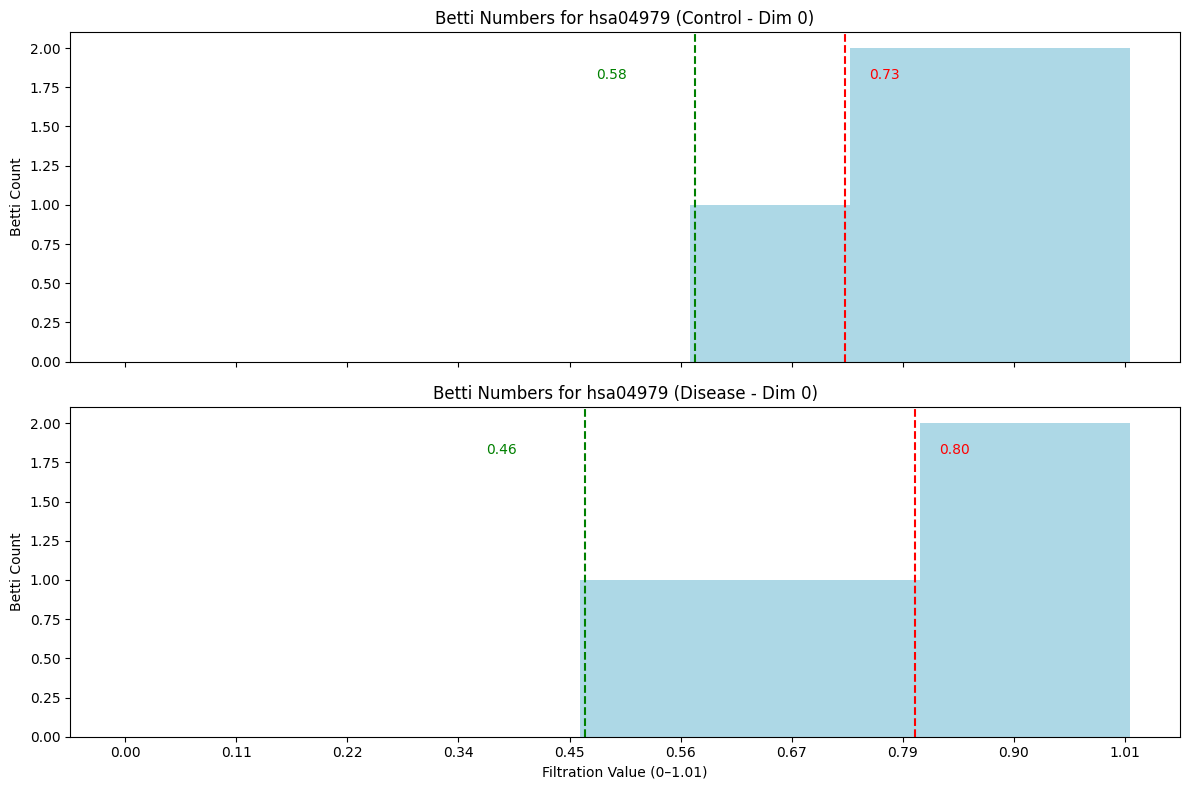

In [99]:
# Select the KEGG pathway ID for analysis
path_id2 = 'hsa04979'

# Extract the dimension-1 Betti numbers for the control group
betti_control = dim1_betti_numbers_dict[path_id2]['control']

# Extract the dimension-1 Betti numbers for the disease group
betti_disease = dim1_betti_numbers_dict[path_id2]['disease']

# Plot and compare the Betti number evolution between control and disease groups
plot_betti_numbers(path_id2, betti_control, betti_disease, save_plot=False)

### Perform the pathway level analysis (GenPath-PPH)

In [100]:
# Step 1 — Run the pathway-level difference analysis for each dimension
#dim0_result_corr = pathway_level_difference_analysis(
 #   path_ids=path_ids,
 #   dim0_betti_numbers_dict=dim0_betti_numbers_dict,
 #   dim1_betti_numbers_dict=dim1_betti_numbers_dict,
 #   top_dim=0,
 #   num_perm=5000
#)

#dim1_result_corr = pathway_level_difference_analysis(
 #   path_ids=path_ids,
 #   dim0_betti_numbers_dict=dim0_betti_numbers_dict,
 #   dim1_betti_numbers_dict=dim1_betti_numbers_dict,
 #   top_dim=1,
 #   num_perm=5000
#)

In [101]:
# Step 1: Run the above cell or load the saved results from the pathway_level_difference_analysis as shown below:
dim0_result_corr = pd.read_csv("Results/Effect_size_KS_test_results_dimension_0_absolute_correlation.csv")
dim1_result_corr = pd.read_csv("Results/Effect_size_KS_test_results_dimension_1_absolute_correlation.csv")

# Step 2 — Annotate each result with its homological dimension
dim0_result_corr["dimension"] = 'Dim 0'
dim1_result_corr["dimension"] = 'Dim 1'

# Step 3 — Combine both dimensions into one DataFrame
dim_metrics_df = pd.concat([dim0_result_corr, dim1_result_corr], ignore_index=True)

# Step 4 — Handle missing values (set NaN to 0 for consistency)
dim_metrics_df = dim_metrics_df.fillna(0)

# Step 5 — Identify significant results based on BH-adjusted p-values (< 0.05)
dim_metrics_df['es_significant'] = dim_metrics_df['es_corrected_pvalue'] < 0.05
dim_metrics_df['ks_significant'] = dim_metrics_df['ks_corrected_pvalue'] < 0.05
dim_metrics_df['es_ks_significant'] = dim_metrics_df['es_significant'] & dim_metrics_df['ks_significant']

# Step 6 — Create readable dimension-specific significance labels
dim_metrics_df["dim_es"] = dim_metrics_df["dimension"] + " (" + dim_metrics_df["es_significant"].astype(str) + ")"
dim_metrics_df["dim_ks"] = dim_metrics_df["dimension"] + " (" + dim_metrics_df["ks_significant"].astype(str) + ")"

# Merge new_df with kegg_filt on 'pathway' (Pathway ID) so we can mapped hsacodes to pathway name
dim_metrics_df = dim_metrics_df.merge(kegg_filt, left_on='path_id', right_on='PathwayID', how='left')

# Create new pathway column with description + ID
dim_metrics_df['full pathway'] = dim_metrics_df['Description'] + ' (' + dim_metrics_df['PathwayID'] + ')'

# Drop the extra columns from kegg_filt
dim_metrics_df = dim_metrics_df.drop(columns=['PathwayID', 'No of genes', 'Available genes', 'Percentage present'])

# Step 7 — Display summary
print(f"Combined results shape: {dim_metrics_df.shape}")
dim_metrics_df.head()

Combined results shape: (502, 16)


,path_id,mean_diff_observed,es_observed,es_raw_pvalue,es_corrected_pvalue,ks_observed,ks_raw_pvalue,ks_corrected_pvalue,dimension,es_significant,ks_significant,es_ks_significant,dim_es,dim_ks,Description,full pathway
0,hsa00010,7.029703,0.364412,0.0110,0.029688,0.188119,0.0422,0.098076,Dim 0,True,False,False,Dim 0 (True),Dim 0 (False),Glycolysis / Gluconeogenesis,Glycolysis / Gluconeogenesis (hsa00010)
1,hsa00020,2.930693,0.303688,0.0332,0.062563,0.188119,0.0224,0.061785,Dim 0,False,False,False,Dim 0 (False),Dim 0 (False),Citrate cycle (TCA cycle),Citrate cycle (TCA cycle) (hsa00020)
2,hsa00030,3.217822,0.361092,0.0128,0.032307,0.297030,0.0002,0.001931,Dim 0,True,True,True,Dim 0 (True),Dim 0 (True),Pentose phosphate pathway,Pentose phosphate pathway (hsa00030)
3,hsa00040,0.089109,0.018751,0.8880,0.898742,0.118812,0.2984,0.390096,Dim 0,False,False,False,Dim 0 (False),Dim 0 (False),Pentose and glucuronate interconversions,Pentose and glucuronate interconversions (hsa0...
4,hsa00051,2.158416,0.217027,0.1254,0.163085,0.168317,0.0800,0.139444,Dim 0,False,False,False,Dim 0 (False),Dim 0 (False),Fructose and mannose metabolism,Fructose and mannose metabolism (hsa00051)


##### Significantly Altered Pathways

In [102]:
# Get dimension-0 pathways significant in the Cohen's d test (p < 0.05)
dim0_paths_es = sorted(dim1_result_corr[dim0_result_corr['es_corrected_pvalue'] < 0.05]['path_id'].tolist())
dim0_pph_es_list = sorted(kegg_filt[kegg_filt['PathwayID'].isin(dim0_paths_es)]['Description'].to_list())
print(len(dim0_pph_es_list))
print(dim0_pph_es_list)

120
['ABC transporters', 'ATP-dependent chromatin remodeling', 'Adipocytokine signaling pathway', 'Adrenergic signaling in cardiomyocytes', 'Alanine, aspartate and glutamate metabolism', 'Aldosterone-regulated sodium reabsorption', 'Aminoacyl-tRNA biosynthesis', 'Apoptosis', 'Arginine and proline metabolism', 'Arginine biosynthesis', 'Ascorbate and aldarate metabolism', 'Autophagy - animal', 'Autophagy - other', 'Basal transcription factors', 'Base excision repair', 'Biosynthesis of unsaturated fatty acids', 'Biotin metabolism', 'Cell cycle', 'Cellular senescence', 'Circadian rhythm', 'Collecting duct acid secretion', 'Complement and coagulation cascades', 'Cytosolic DNA-sensing pathway', 'D-Amino acid metabolism', 'DNA replication', 'Dopaminergic synapse', 'Drug metabolism - cytochrome P450', 'ECM-receptor interaction', 'Fanconi anemia pathway', 'Fatty acid degradation', 'Fc epsilon RI signaling pathway', 'Fc gamma R-mediated phagocytosis', 'Ferroptosis', 'Galactose metabolism', 'Gluc

In [103]:
# Get dimension-0 pathways significant in the KS test (p < 0.05)
dim0_paths_ks = sorted(dim0_result_corr[dim0_result_corr['ks_corrected_pvalue'] < 0.05]['path_id'].tolist())
dim0_pph_ks_list = sorted(kegg_filt[kegg_filt['PathwayID'].isin(dim0_paths_ks)]['Description'].to_list())
print(len(dim0_pph_ks_list))
print(dim0_pph_ks_list)

80
['Alanine, aspartate and glutamate metabolism', 'Aldosterone-regulated sodium reabsorption', 'Aminoacyl-tRNA biosynthesis', 'Apoptosis', 'Apoptosis - multiple species', 'Ascorbate and aldarate metabolism', 'Autophagy - other', 'Bile secretion', 'Biotin metabolism', 'Butanoate metabolism', 'Caffeine metabolism', 'Cell cycle', 'Circadian rhythm', 'Complement and coagulation cascades', 'Cytokine-cytokine receptor interaction', 'Cytosolic DNA-sensing pathway', 'D-Amino acid metabolism', 'Drug metabolism - cytochrome P450', 'Endocytosis', 'Fanconi anemia pathway', 'Fatty acid biosynthesis', 'Fatty acid degradation', 'Fc epsilon RI signaling pathway', 'Ferroptosis', 'Galactose metabolism', 'Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate', 'Glycosaminoglycan biosynthesis - heparan sulfate / heparin', 'Glycosylphosphatidylinositol (GPI)-anchor biosynthesis', 'Glyoxylate and dicarboxylate metabolism', 'Hedgehog signaling pathway', 'Histidine metabolism', 'Homologous 

In [104]:
# Get dimension-1 pathways significant in the Cohen's d test (p < 0.05)
dim1_paths_es = sorted(dim1_result_corr[dim1_result_corr['es_corrected_pvalue'] < 0.05]['path_id'].tolist())
dim1_pph_es_list = sorted(kegg_filt[kegg_filt['PathwayID'].isin(dim1_paths_es)]['Description'].to_list())
print(len(dim1_pph_es_list))
print(dim1_pph_es_list)

144
['ABC transporters', 'AMPK signaling pathway', 'ATP-dependent chromatin remodeling', 'Adipocytokine signaling pathway', 'Aldosterone synthesis and secretion', 'Amino sugar and nucleotide sugar metabolism', 'Aminoacyl-tRNA biosynthesis', 'Arginine biosynthesis', 'Ascorbate and aldarate metabolism', 'Autophagy - animal', 'Basal transcription factors', 'Base excision repair', 'Bile secretion', 'Biosynthesis of unsaturated fatty acids', 'Biotin metabolism', 'C-type lectin receptor signaling pathway', 'Caffeine metabolism', 'Carbohydrate digestion and absorption', 'Cellular senescence', 'Cholinergic synapse', 'Collecting duct acid secretion', 'Complement and coagulation cascades', 'Cortisol synthesis and secretion', 'Cysteine and methionine metabolism', 'Cytokine-cytokine receptor interaction', 'Cytosolic DNA-sensing pathway', 'D-Amino acid metabolism', 'DNA replication', 'ErbB signaling pathway', 'Fanconi anemia pathway', 'Fat digestion and absorption', 'Fatty acid biosynthesis', 'Fatt

In [105]:
# Get dimension-1 pathways significant in the KS test (p < 0.05)
dim1_paths_ks = sorted(dim1_result_corr[dim1_result_corr['ks_corrected_pvalue'] < 0.05]['path_id'].tolist())
dim1_pph_ks_list = sorted(kegg_filt[kegg_filt['PathwayID'].isin(dim1_paths_ks)]['Description'].to_list())
print(len(dim1_pph_ks_list))
print(dim1_pph_ks_list)

128
['AMPK signaling pathway', 'Adipocytokine signaling pathway', 'Alanine, aspartate and glutamate metabolism', 'Aldosterone-regulated sodium reabsorption', 'Amino sugar and nucleotide sugar metabolism', 'Aminoacyl-tRNA biosynthesis', 'Ascorbate and aldarate metabolism', 'Autophagy - animal', 'Axon guidance', 'B cell receptor signaling pathway', 'C-type lectin receptor signaling pathway', 'Cellular senescence', 'Chemokine signaling pathway', 'Cholinergic synapse', 'Circadian rhythm', 'Complement and coagulation cascades', 'Cortisol synthesis and secretion', 'Cysteine and methionine metabolism', 'Cytokine-cytokine receptor interaction', 'Dopaminergic synapse', 'Drug metabolism - other enzymes', 'Endocytosis', 'ErbB signaling pathway', 'Ether lipid metabolism', 'Fat digestion and absorption', 'Fatty acid biosynthesis', 'Fatty acid degradation', 'Fatty acid elongation', 'Fc epsilon RI signaling pathway', 'Fc gamma R-mediated phagocytosis', 'Ferroptosis', 'Folate biosynthesis', 'FoxO sign

In [106]:
# Get dimension-0 pathways significant in both ES and KS tests (p < 0.05)
dim0_paths_both = sorted(dim0_result_corr[
    (dim0_result_corr['es_corrected_pvalue'] < 0.05) &
    (dim0_result_corr['ks_corrected_pvalue'] < 0.05)
]['path_id'].tolist())

# Retrieve the corresponding pathway descriptions for dimension-0
dim0_pph_both_list = sorted(kegg_filt[kegg_filt['PathwayID'].isin(dim0_paths_both)]['Description'].to_list())

# Display the count and list of significant dimension-0 pathways
print(len(dim0_pph_both_list))
print(dim0_pph_both_list)

59
['Alanine, aspartate and glutamate metabolism', 'Aldosterone-regulated sodium reabsorption', 'Aminoacyl-tRNA biosynthesis', 'Apoptosis', 'Ascorbate and aldarate metabolism', 'Autophagy - other', 'Biotin metabolism', 'Cell cycle', 'Circadian rhythm', 'Complement and coagulation cascades', 'Cytosolic DNA-sensing pathway', 'D-Amino acid metabolism', 'Drug metabolism - cytochrome P450', 'Fanconi anemia pathway', 'Fatty acid degradation', 'Fc epsilon RI signaling pathway', 'Ferroptosis', 'Galactose metabolism', 'Glycosaminoglycan biosynthesis - chondroitin sulfate / dermatan sulfate', 'Glycosaminoglycan biosynthesis - heparan sulfate / heparin', 'Glycosylphosphatidylinositol (GPI)-anchor biosynthesis', 'Glyoxylate and dicarboxylate metabolism', 'Hedgehog signaling pathway', 'Histidine metabolism', 'Homologous recombination', 'Intestinal immune network for IgA production', 'JAK-STAT signaling pathway', 'Lipoic acid metabolism', 'Lysine degradation', 'Mannose type O-glycan biosynthesis', '

In [107]:
# Get dimension-1 pathways significant in both ES and KS tests (p < 0.05)
dim1_paths_both = sorted(dim1_result_corr[
    (dim1_result_corr['es_corrected_pvalue'] < 0.05) &
    (dim1_result_corr['ks_corrected_pvalue'] < 0.05)
]['path_id'].tolist())

# Retrieve the corresponding pathway descriptions for dimension-1
dim1_pph_both_list = sorted(kegg_filt[kegg_filt['PathwayID'].isin(dim1_paths_both)]['Description'].to_list())

# Display the count and list of significant dimension-1 pathways
print(len(dim1_pph_both_list))
print(dim1_pph_both_list)

85
['AMPK signaling pathway', 'Adipocytokine signaling pathway', 'Amino sugar and nucleotide sugar metabolism', 'Aminoacyl-tRNA biosynthesis', 'Ascorbate and aldarate metabolism', 'Autophagy - animal', 'C-type lectin receptor signaling pathway', 'Cellular senescence', 'Cholinergic synapse', 'Complement and coagulation cascades', 'Cortisol synthesis and secretion', 'Cysteine and methionine metabolism', 'Cytokine-cytokine receptor interaction', 'ErbB signaling pathway', 'Fat digestion and absorption', 'Fatty acid biosynthesis', 'Fatty acid degradation', 'Fatty acid elongation', 'Fc epsilon RI signaling pathway', 'Fc gamma R-mediated phagocytosis', 'Ferroptosis', 'Folate biosynthesis', 'FoxO signaling pathway', 'Fructose and mannose metabolism', 'GABAergic synapse', 'Galactose metabolism', 'Glucagon signaling pathway', 'Glutathione metabolism', 'Glycerolipid metabolism', 'Glycine, serine and threonine metabolism', 'Glycosaminoglycan biosynthesis - heparan sulfate / heparin', 'Glycosphingo

In [108]:
# The overlap between dim0_pph_both_list and dim1_pph_both_list
# represents pathways significantly identified as altered under the studied condition.
# Compute the overlap between dimension-0 and dimension-1 significant pathways
genpath_pph_paths = sorted(set(dim0_pph_both_list).intersection(dim1_pph_both_list))

# Display results
print(len(genpath_pph_paths))
print(genpath_pph_paths)

31
['Aminoacyl-tRNA biosynthesis', 'Ascorbate and aldarate metabolism', 'Complement and coagulation cascades', 'Fatty acid degradation', 'Fc epsilon RI signaling pathway', 'Ferroptosis', 'Galactose metabolism', 'Glycosaminoglycan biosynthesis - heparan sulfate / heparin', 'Glyoxylate and dicarboxylate metabolism', 'Intestinal immune network for IgA production', 'JAK-STAT signaling pathway', 'Lipoic acid metabolism', 'Lysine degradation', 'Mannose type O-glycan biosynthesis', 'NF-kappa B signaling pathway', 'Neuroactive ligand-receptor interaction', 'Nicotinate and nicotinamide metabolism', 'Pentose phosphate pathway', 'Primary bile acid biosynthesis', 'Prolactin signaling pathway', 'Propanoate metabolism', 'RNA degradation', 'Selenocompound metabolism', 'Sphingolipid signaling pathway', 'Steroid hormone biosynthesis', 'Synaptic vesicle cycle', 'Terpenoid backbone biosynthesis', 'Th17 cell differentiation', 'Thyroid hormone synthesis', 'Vitamin B6 metabolism', 'p53 signaling pathway']


### Visualizations - Principal Component Analysis (PCA)
This visualization assesses whether significant pathways, identified by their topological differences (via KS and Cohen’s d tests), form distinguishable clusters.

PCA helps to examine how the significant and non-significant pathways separate in the feature space, supporting the idea that disease-related pathways exhibit distinct topological signatures.

In [109]:
# Select features for PCA
pca_data = dim_metrics_df[['es_observed', 'mean_diff_observed', 'ks_observed']]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)

# Apply PCA
pca = PCA(n_components=3, random_state=0)
pca_result = pca.fit_transform(scaled_data)

# Add PCA results back to the DataFrame
dim_metrics_df['PCA1'] = pca_result[:, 0]
dim_metrics_df['PCA2'] = pca_result[:, 1]
dim_metrics_df['PCA3'] = pca_result[:, 2]

# Display the updated DataFrame
dim_metrics_df.head()

,path_id,mean_diff_observed,es_observed,es_raw_pvalue,es_corrected_pvalue,ks_observed,ks_raw_pvalue,ks_corrected_pvalue,dimension,es_significant,ks_significant,es_ks_significant,dim_es,dim_ks,Description,full pathway,PCA1,PCA2,PCA3
0,hsa00010,7.029703,0.364412,0.0110,0.029688,0.188119,0.0422,0.098076,Dim 0,True,False,False,Dim 0 (True),Dim 0 (False),Glycolysis / Gluconeogenesis,Glycolysis / Gluconeogenesis (hsa00010),1.377598,0.041257,0.110870
1,hsa00020,2.930693,0.303688,0.0332,0.062563,0.188119,0.0224,0.061785,Dim 0,False,False,False,Dim 0 (False),Dim 0 (False),Citrate cycle (TCA cycle),Citrate cycle (TCA cycle) (hsa00020),0.686659,0.066828,-0.333349
2,hsa00030,3.217822,0.361092,0.0128,0.032307,0.297030,0.0002,0.001931,Dim 0,True,True,True,Dim 0 (True),Dim 0 (True),Pentose phosphate pathway,Pentose phosphate pathway (hsa00030),0.905422,1.006254,-0.452387
3,hsa00040,0.089109,0.018751,0.8880,0.898742,0.118812,0.2984,0.390096,Dim 0,False,False,False,Dim 0 (False),Dim 0 (False),Pentose and glucuronate interconversions,Pentose and glucuronate interconversions (hsa0...,-0.326252,-0.467950,-0.119741
4,hsa00051,2.158416,0.217027,0.1254,0.163085,0.168317,0.0800,0.139444,Dim 0,False,False,False,Dim 0 (False),Dim 0 (False),Fructose and mannose metabolism,Fructose and mannose metabolism (hsa00051),0.392049,-0.084916,-0.256130


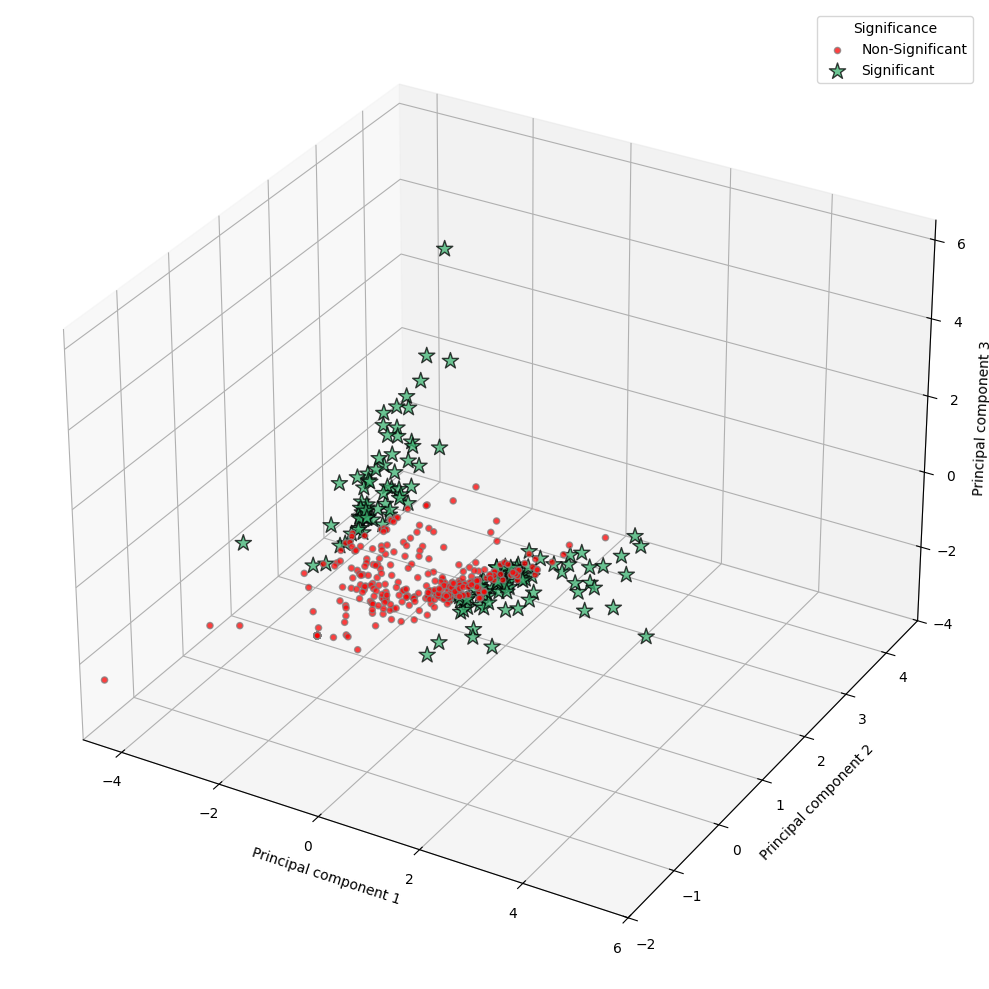

In [110]:
# Define color mapping based on significance
colors = {'non_significant': 'red', 'significant': 'mediumseagreen'}

# Define significance criteria
significance_criteria = ['es_ks_significant']
title = 'Significance in Effect Size (Cohen\'s $d$) and KS Test'

# Create a single figure and axis for the 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot non-significant and significant pathways based on 'es_ks_significant'
for sig_col in significance_criteria:
    
    # Plot non-significant pathways
    subset_non_sig = dim_metrics_df[~dim_metrics_df[sig_col]]
    ax.scatter(
        subset_non_sig['PCA1'], 
        subset_non_sig['PCA2'], 
        subset_non_sig['PCA3'],  # Assuming PCA3 is the 3rd component
        label=f'Non-Significant', 
        alpha=0.75, 
        edgecolor='gray',
        color=colors['non_significant']
    )

    # Plot significant pathways
    subset_sig = dim_metrics_df[dim_metrics_df[sig_col]]
    ax.scatter(
        subset_sig['PCA1'], 
        subset_sig['PCA2'], 
        subset_sig['PCA3'],  # Assuming PCA3 is the 3rd component
        label=f'Significant', 
        alpha=0.75, 
        edgecolor='black', 
        marker='*', 
        s=150,  # Larger size for significance
        color=colors['significant']
    )

# Set labels for the 3D plot
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3')  # Adding the z-axis label for 3D
#ax.set_title(title)

ax.set_xlim(-4.8, 6)
ax.set_ylim(-2, 4.8)
ax.set_zlim(-4, 6.5)

# Display the legend
ax.legend(title='Significance')

# Adjust layout and save as PNG
plt.tight_layout()

# Show the plot
plt.show()

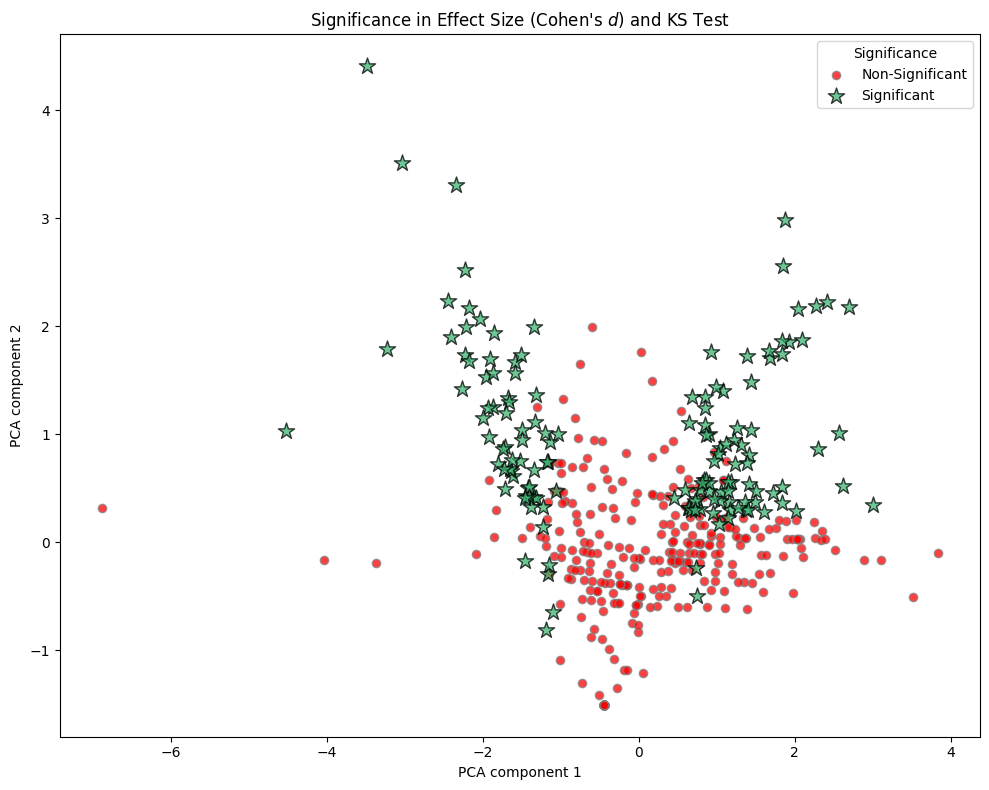

In [111]:
#  Define color mapping based on significance
colors = {'non_significant': 'red', 'significant': 'mediumseagreen'}

# Define significance criteria
significance_criteria = ['es_ks_significant']
title = 'Significance in Effect Size (Cohen\'s $d$) and KS Test'

# Create a figure and axis for the 2D plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot non-significant and significant pathways based on 'es_ks_significant'
for sig_col in significance_criteria:
    
    # Plot non-significant pathways
    subset_non_sig = dim_metrics_df[~dim_metrics_df[sig_col]]
    ax.scatter(
        subset_non_sig['PCA1'], 
        subset_non_sig['PCA2'], 
        label=f'Non-Significant', 
        alpha=0.75, 
        edgecolor='gray',
        color=colors['non_significant']
    )

    # Plot significant pathways
    subset_sig = dim_metrics_df[dim_metrics_df[sig_col]]
    ax.scatter(
        subset_sig['PCA1'], 
        subset_sig['PCA2'], 
        label=f'Significant', 
        alpha=0.75, 
        edgecolor='black', 
        marker='*', 
        s=150,  # Larger size for significance
        color=colors['significant']
    )

# Set labels for the 2D plot
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')
ax.set_title(title)

# Display the legend
ax.legend(title='Significance')

# Adjust layout and save as PNG
plt.tight_layout()

# Show the plot
plt.show()

In [112]:
# Get variances and evaluate clustering robustness
explained_variance = pca.explained_variance_ratio_
sil = silhouette_score(pca_result, dim_metrics_df['es_ks_significant'].astype(int))

print("Explained variance by each PC:", explained_variance)
print("Cumulative variance:", explained_variance.cumsum())
print(f"Clustering robustness was evaluated using silhouette score: {sil:.2f}")

Explained variance by each PC: [0.50778404 0.3329264  0.15928956]
Cumulative variance: [0.50778404 0.84071044 1.        ]
Clustering robustness was evaluated using silhouette score: 0.25


#### Persistent Homology with Topological Descriptors (PH-TD) 
This represents the results obtained using our previous persistent homology–based approach. The list of significantly identified pathways from PH-TD will be compared with those obtained from GenPath-PPH.

In [113]:
phtd_pathway_list = ["RNA polymerase", "Protein processing in endoplasmic reticulum", "Base excision repair", "Virion - herpesvirus", 
                         "ABC transporters", "Apelin signaling pathway", "p53 signaling pathway", "IL-17 signaling pathway", 
                         "Collecting duct acid secretion", "Synaptic vesicle cycle", "Riboflavin metabolism", "Citrate/TCA cycle", "Sulfur metabolism",
                         "Ascorbate and aldarate metabolism", "Drug metabolism - cytochrome P450", "Glycine, serine and threonine metabolism", 
                         "Primary bile acid biosynthesis", "Phosphonate and phosphinate metabolism", "Histidine metabolism", "Tryptophan metabolism", 
                         "beta-Alanine metabolism", "Pantothenate and CoA biosynthesis", "Porphyrin metabolism"]
print(len(phtd_pathway_list))
print(sorted(phtd_pathway_list))

23
['ABC transporters', 'Apelin signaling pathway', 'Ascorbate and aldarate metabolism', 'Base excision repair', 'Citrate/TCA cycle', 'Collecting duct acid secretion', 'Drug metabolism - cytochrome P450', 'Glycine, serine and threonine metabolism', 'Histidine metabolism', 'IL-17 signaling pathway', 'Pantothenate and CoA biosynthesis', 'Phosphonate and phosphinate metabolism', 'Porphyrin metabolism', 'Primary bile acid biosynthesis', 'Protein processing in endoplasmic reticulum', 'RNA polymerase', 'Riboflavin metabolism', 'Sulfur metabolism', 'Synaptic vesicle cycle', 'Tryptophan metabolism', 'Virion - herpesvirus', 'beta-Alanine metabolism', 'p53 signaling pathway']


#### DESEq2 Analysis
The differential expression analysis was performed using the DESeq2 package in R. The resulting data are required for both the hypergeometric enrichment analysis (HGEA) and the gene set enrichment analysis (GSEA) methods.

In [114]:
# Load the data obtained from differential expression analysis 
dseq = pd.read_csv('PBMC_RNASeq_PRNA739257_DESeq2_results_symbol.csv', header=0)
dseq = dseq.rename(columns={'Unnamed: 0': 'Symbol'})
dseq = dseq.set_index('Symbol')
dseq.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Symbol,,,,,,
TSPAN6,5.528638,-0.331951,0.394287,-0.841902,0.399843,0.574361
DPM1,317.959510,-0.030164,0.094772,-0.318279,0.750273,0.850135
SCYL3,428.616401,-0.096691,0.087706,-1.102445,0.270268,0.447751
FIRRM,178.707651,0.041097,0.105302,0.390276,0.696332,0.812523
FGR,6642.868462,0.700604,0.155980,4.491634,0.000007,0.000131


In [115]:
# Select genes with adjusted p-value (FDR) < 0.05 — statistically significant
d_pvalue = dseq[dseq['padj'] < 0.05]
d_pvalue.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Symbol,,,,,,
FGR,6642.868462,0.700604,0.155980,4.491634,0.000007,0.000131
FUCA2,320.460224,0.356009,0.097796,3.640334,0.000272,0.002291
NFYA,785.521655,-0.188005,0.048706,-3.860018,0.000113,0.001146
NIPAL3,1038.636164,-0.260869,0.085165,-3.063092,0.002191,0.011748
ENPP4,629.301706,-0.672131,0.150128,-4.477046,0.000008,0.000138


In [116]:
# From those significant genes, select ones with |log2FoldChange| ≥ 1 — biologically meaningful change
d_pvalue_lfc = d_pvalue[np.abs(d_pvalue['log2FoldChange']) >= 1]
d_pvalue_lfc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Symbol,,,,,,
ICA1,62.901829,1.102517,0.233004,4.731751,2.225910e-06,5.375980e-05
TFPI,212.166125,1.579177,0.300897,5.248232,1.535655e-07,6.906848e-06
PDK4,784.849689,1.333536,0.243932,5.466845,4.581167e-08,2.670762e-06
SLC22A16,60.743829,1.698428,0.257619,6.592781,4.316618e-11,1.440624e-08
ABCB5,0.946818,2.713633,1.093687,2.481179,1.309487e-02,4.800202e-02


In [117]:
# Get the list of significant gene IDs
significant_degs = d_pvalue_lfc.index.tolist()
len(significant_degs)

1251

In [118]:
# Count upregulated genes (log2FoldChange > 0)
num_up = (d_pvalue_lfc['log2FoldChange'] > 0).sum()

# Count downregulated genes (log2FoldChange < 0)
num_down = (d_pvalue_lfc['log2FoldChange'] < 0).sum()

# Summary of differential expression
print(f"Total significant genes: {len(significant_degs)} "
      f"({num_up} upregulated, {num_down} downregulated)")

Total significant genes: 1251 (1095 upregulated, 156 downregulated)


In [119]:
# Subset the main expression dataframe to include only significant genes
df_both = df_all.loc[df_all.index.isin(significant_degs)]
print(df_both.shape)
df_both.head()

(1251, 34)


,C6,C7,C5,C61,C4,C19,C29,C2,C30,C32,...,L31,L39,L41,L42,L44,L46,L51,L56,L7,L9
Symbol,,,,,,,,,,,,,,,,,,,,,
ICA1,0.597612,0.619728,0.693132,0.845248,0.661148,0.801161,0.857750,0.651129,0.732275,0.992429,...,0.916826,0.738821,1.077795,0.825403,0.662925,0.781696,0.847364,0.809036,0.749945,1.546657
TFPI,1.310808,1.482612,1.595432,1.977311,1.533429,0.919971,2.240779,1.992750,1.629443,1.495564,...,2.013978,1.051670,1.776863,1.359328,1.531581,1.540764,2.046576,3.456593,1.886562,3.313304
PDK4,5.183518,3.904443,4.539885,2.547735,4.680805,4.330056,3.874815,4.889512,3.689969,4.937054,...,5.124807,4.816154,4.929170,5.329231,4.917340,5.489063,5.889290,5.565087,5.315977,6.894835
SLC22A16,1.129064,0.917769,1.641195,0.974262,1.188779,1.079458,0.162375,1.207597,0.951429,0.583809,...,1.926842,0.912062,1.924653,1.668833,2.466973,1.276951,1.725127,1.789954,1.175043,2.241988
ABCB5,0.000000,0.000000,0.000000,0.036669,0.000000,0.000000,0.042185,0.000000,0.000000,0.000000,...,0.000000,0.054857,0.000000,0.000000,0.000000,0.133145,0.000000,0.182443,0.000000,0.033129


#### Hypergeometric Enrichment Analysis (HGEA) 
This method identifies pathways significantly enriched with differentially expressed genes using the hypergeometric test. The list of significant pathways will be compared with those from GenPath-PPH.

In [120]:
# Create a dictionary to store per-pathway DEG statistics
deseq_pathways = {
    'Pathway': kegg_pathways_expressions.keys(),
    'Genes (Pathway)': [],  # Total genes in each pathway
    'Genes (DEG)': [],      # Number of DEGs found in each pathway
    'Percentage': []        # Percentage of DEGs among pathway genes
}

# Loop through each KEGG pathway to calculate DEG counts and proportions
for key, value in kegg_pathways_expressions.items():
    # Select DEGs that belong to the current pathway
    data = d_pvalue_lfc.loc[d_pvalue_lfc.index.isin(value.index)]
    
    # Count total genes in the pathway
    deseq_pathways['Genes (Pathway)'].append(len(value))
    
    # Count DEGs in the pathway
    deseq_pathways['Genes (DEG)'].append(len(data))
    
    # Compute percentage of DEGs among pathway genes
    percentage = (len(data) / len(value)) * 100
    deseq_pathways['Percentage'].append(percentage)
    
# Convert results into a DataFrame
deseq_pathways = pd.DataFrame(deseq_pathways).round(2)
print(deseq_pathways.shape)
deseq_pathways.head()

(251, 4)


,Pathway,Genes (Pathway),Genes (DEG),Percentage
0,hsa00010,53,3,5.66
1,hsa00020,27,0,0.00
2,hsa00030,26,3,11.54
3,hsa00040,17,1,5.88
4,hsa00051,31,2,6.45


In [121]:
# Create a dictionary version for convenient access 
deseq_pathways_dict = {}
for index, (key, value) in enumerate(kegg_pathways_expressions.items()):
    genes_path = deseq_pathways.loc[index].iloc[1]  # Total genes in pathway
    genes_deseq = deseq_pathways.loc[index].iloc[2]  # DEGs in pathway
    percent = deseq_pathways.loc[index].iloc[3]      # DEG percentage
    deseq_pathways_dict[key] = [genes_path, genes_deseq, percent]

In [122]:
# Define parameters for enrichment test
N = df_all.shape[0]   # Total genes in the dataset
n = df_both.shape[0]  # Total DEGs identified

# Store enrichment p-values
enrichment_pvalues = {
    'PathwayID': kegg_pathways_expressions.keys(),
    'pvalue': []
}

# Perform hypergeometric test for each pathway
for key, value in kegg_pathways_expressions.items():    
    path_data = deseq_pathways_dict[key]   # [total genes, DEGs, percent]
    pvalue = hypergeom.sf(path_data[1] - 1, N, path_data[0], n)  # P(X ≥ x)
    enrichment_pvalues['pvalue'].append(pvalue)

# Convert to DataFrame and apply Benjamini–Hochberg FDR correction
enrichment_pvalues = pd.DataFrame(enrichment_pvalues)
pvals = enrichment_pvalues['pvalue'].to_list()
adj_pvals = multipletests(pvals, method='fdr_bh')[1]
enrichment_pvalues['adjp'] = adj_pvals

enrichment_pvalues.head()

,PathwayID,pvalue,adjp
0,hsa00010,0.555171,1.00000
1,hsa00020,1.000000,1.00000
2,hsa00030,0.165305,0.63833
3,hsa00040,0.613220,1.00000
4,hsa00051,0.507904,1.00000


In [123]:
# Identify significantly enriched pathways (FDR < 0.05)
deseq_paths_adjp = enrichment_pvalues[enrichment_pvalues['adjp'] < 0.05]
print(len(deseq_paths_adjp))
deseq_paths_adjp

16


,PathwayID,pvalue,adjp
50,hsa00561,1.334637e-03,0.025769
105,hsa03320,2.136259e-04,0.005958
116,hsa04020,2.645860e-03,0.041507
119,hsa04060,7.729772e-05,0.002425
128,hsa04080,1.024257e-03,0.021424
141,hsa04145,4.548544e-04,0.010379
163,hsa04380,1.319036e-05,0.000697
167,hsa04512,2.374850e-05,0.000923
173,hsa04610,4.990005e-09,0.000001
174,hsa04611,2.574592e-05,0.000923


In [124]:
# Extract the list of enriched pathways (HGEA)
enrich_degs_pathways = deseq_paths_adjp['PathwayID'].tolist()
hgea_pathway_list = kegg_filt[kegg_filt['PathwayID'].isin(enrich_degs_pathways)]['Description'].tolist()
print(hgea_pathway_list)

['Glycerolipid metabolism', 'JAK-STAT signaling pathway', 'Calcium signaling pathway', 'Neuroactive ligand-receptor interaction', 'Cytokine-cytokine receptor interaction', 'ECM-receptor interaction', 'Phagosome', 'Hematopoietic cell lineage', 'Complement and coagulation cascades', 'Platelet activation', 'Neutrophil extracellular trap formation', 'IL-17 signaling pathway', 'PPAR signaling pathway', 'Fat digestion and absorption', 'Cholesterol metabolism', 'Osteoclast differentiation']


#### Gene Set Enrichment Analysis (GSEA) 
This method evaluates whether predefined gene sets from the KEGG database show significant enrichment across a ranked list of genes ordered by log fold change (from most positive to most negative). The results will be compared with those obtained from GenPath-PPH.

In [125]:
# list of genes signfifanctly differentialy expressed
gene_list = d_pvalue_lfc.index.tolist()
background = dseq.index.tolist()

In [126]:
# Assuming you have a DataFrame `df` with 'gene', 'logFC', and 'pvalue' columns
ranked_lfc = pd.read_csv("ranked_genes_lfc.rnk", header=None, index_col=0, sep="\t")

# Run GSEA using KEGG pathways or any other gene sets
gsea_results = gp.prerank(rnk=ranked_lfc, 
                          gene_sets='KEGG_2021_Human',
                          outdir=None, 
                          permutation_num=1000,  # Number of permutations for significance
                          seed=0,
                          verbose=True # see what's going on behind the scenes
                         )

2025-11-07 23:37:18,855 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-11-07 23:37:18,858 [INFO] Parsing data files for GSEA.............................
2025-11-07 23:37:18,900 [INFO] Enrichr library gene sets already downloaded in: C:\Users\MSAbdullahi\.cache/gseapy, use local file
2025-11-07 23:37:19,012 [INFO] 0020 gene_sets have been filtered out when max_size=500 and min_size=15
2025-11-07 23:37:19,014 [INFO] 0300 gene_sets used for further statistical testing.....
2025-11-07 23:37:19,035 [INFO] Start to run GSEA...Might take a while..................
2025-11-07 23:37:50,777 [INFO] Congratulations. GSEApy runs successfully................



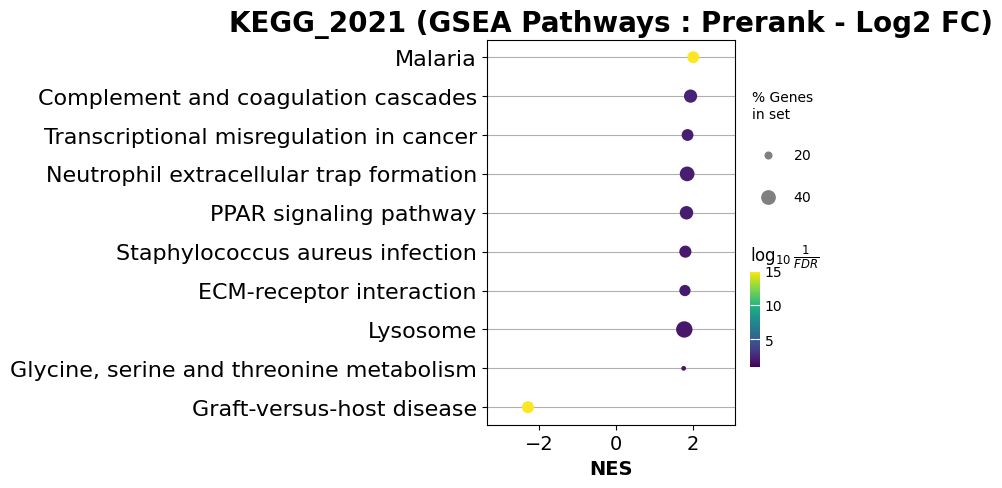

In [127]:
# To save your figure, make sure that ``ofname`` is not None
ax = dotplot(gsea_results.res2d,
             column="FDR q-val",
             title='KEGG_2021 (GSEA Pathways : Prerank - Log2 FC)',
             cmap=plt.cm.viridis,
             size=4, # adjust dot size
             figsize=(4,5), cutoff=0.05, show_ring=False)

In [128]:
# Extract the list of enriched pathways (GSEA)
gsea_lfc_ranked_pathways_list = gsea_results.res2d[gsea_results.res2d['FDR q-val'] < 0.05]['Term'].tolist()
print(len(gsea_lfc_ranked_pathways_list))
print(gsea_lfc_ranked_pathways_list)

34
['Graft-versus-host disease', 'Malaria', 'Complement and coagulation cascades', 'Transcriptional misregulation in cancer', 'Neutrophil extracellular trap formation', 'PPAR signaling pathway', 'Natural killer cell mediated cytotoxicity', 'Staphylococcus aureus infection', 'ECM-receptor interaction', 'Lysosome', 'Glycine, serine and threonine metabolism', 'Allograft rejection', 'Bladder cancer', 'Cholesterol metabolism', 'Porphyrin and chlorophyll metabolism', 'Platelet activation', 'Drug metabolism', 'Adipocytokine signaling pathway', 'Mineral absorption', 'AMPK signaling pathway', 'Glycolysis / Gluconeogenesis', 'Fructose and mannose metabolism', 'African trypanosomiasis', 'Pentose phosphate pathway', 'Pantothenate and CoA biosynthesis', 'Pyrimidine metabolism', 'Histidine metabolism', 'Collecting duct acid secretion', 'Phagosome', 'Alcoholism', 'Synaptic vesicle cycle', 'Ferroptosis', 'Glutathione metabolism', 'Olfactory transduction']


In [129]:
# Extract the list of enriched pathway (GSEA) in our study
gsea_pathway_list = [path for path in gsea_lfc_ranked_pathways_list if path in dim_metrics_df['Description'].tolist()]
rename_paths = ['Porphyrin metabolism', 'Drug metabolism - cytochrome P450']
gsea_pathway_list.extend(rename_paths)
print(len(gsea_pathway_list))
print(gsea_pathway_list)

26
['Complement and coagulation cascades', 'Neutrophil extracellular trap formation', 'PPAR signaling pathway', 'Natural killer cell mediated cytotoxicity', 'ECM-receptor interaction', 'Lysosome', 'Glycine, serine and threonine metabolism', 'Cholesterol metabolism', 'Platelet activation', 'Adipocytokine signaling pathway', 'Mineral absorption', 'AMPK signaling pathway', 'Glycolysis / Gluconeogenesis', 'Fructose and mannose metabolism', 'Pentose phosphate pathway', 'Pantothenate and CoA biosynthesis', 'Pyrimidine metabolism', 'Histidine metabolism', 'Collecting duct acid secretion', 'Phagosome', 'Synaptic vesicle cycle', 'Ferroptosis', 'Glutathione metabolism', 'Olfactory transduction', 'Porphyrin metabolism', 'Drug metabolism - cytochrome P450']


### Visualization - Upsetplot 
This visualization illustrates the intersections among pathway sets identified as significant by different criteria or methods.

It allows comparison between the current approach (GenPath-PPH) and baseline or benchmark methods (PH-TD, HGEA, and GSEA), highlighting shared and unique pathway detections across approaches.

c:\Users\MSAbdullahi\AppData\Local\Programs\Python\Python313\Lib\site-packages\upsetplot\data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
c:\Users\MSAbdullahi\AppData\Local\Programs\Python\Python313\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the or

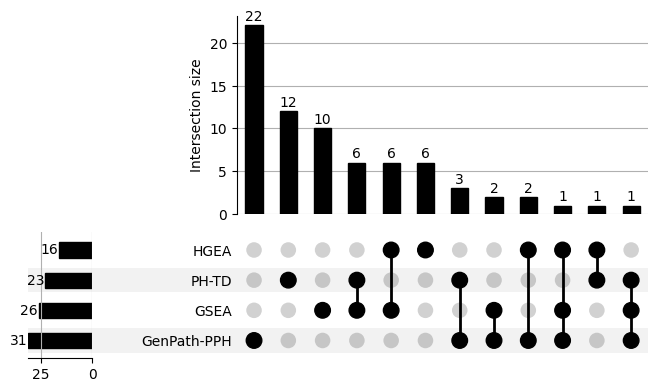

In [130]:
# Overlap between the four compared methods
contents = {'GenPath-PPH': genpath_pph_paths,
            'PH-TD': phtd_pathway_list,
            'HGEA': hgea_pathway_list,
            'GSEA': gsea_pathway_list
           }

data = from_contents(contents)

upset = UpSet(data, sort_by='cardinality', sort_categories_by='cardinality', show_counts=True)
upset.plot()

plt.show()

## Visualizations – Venn Diagram

This diagram shows the overlap between dimension 0 and dimension 1 features based on significant differences identified by the KS test and Cohen’s $d$ effect size, highlighting shared and unique topological patterns across dimensions.

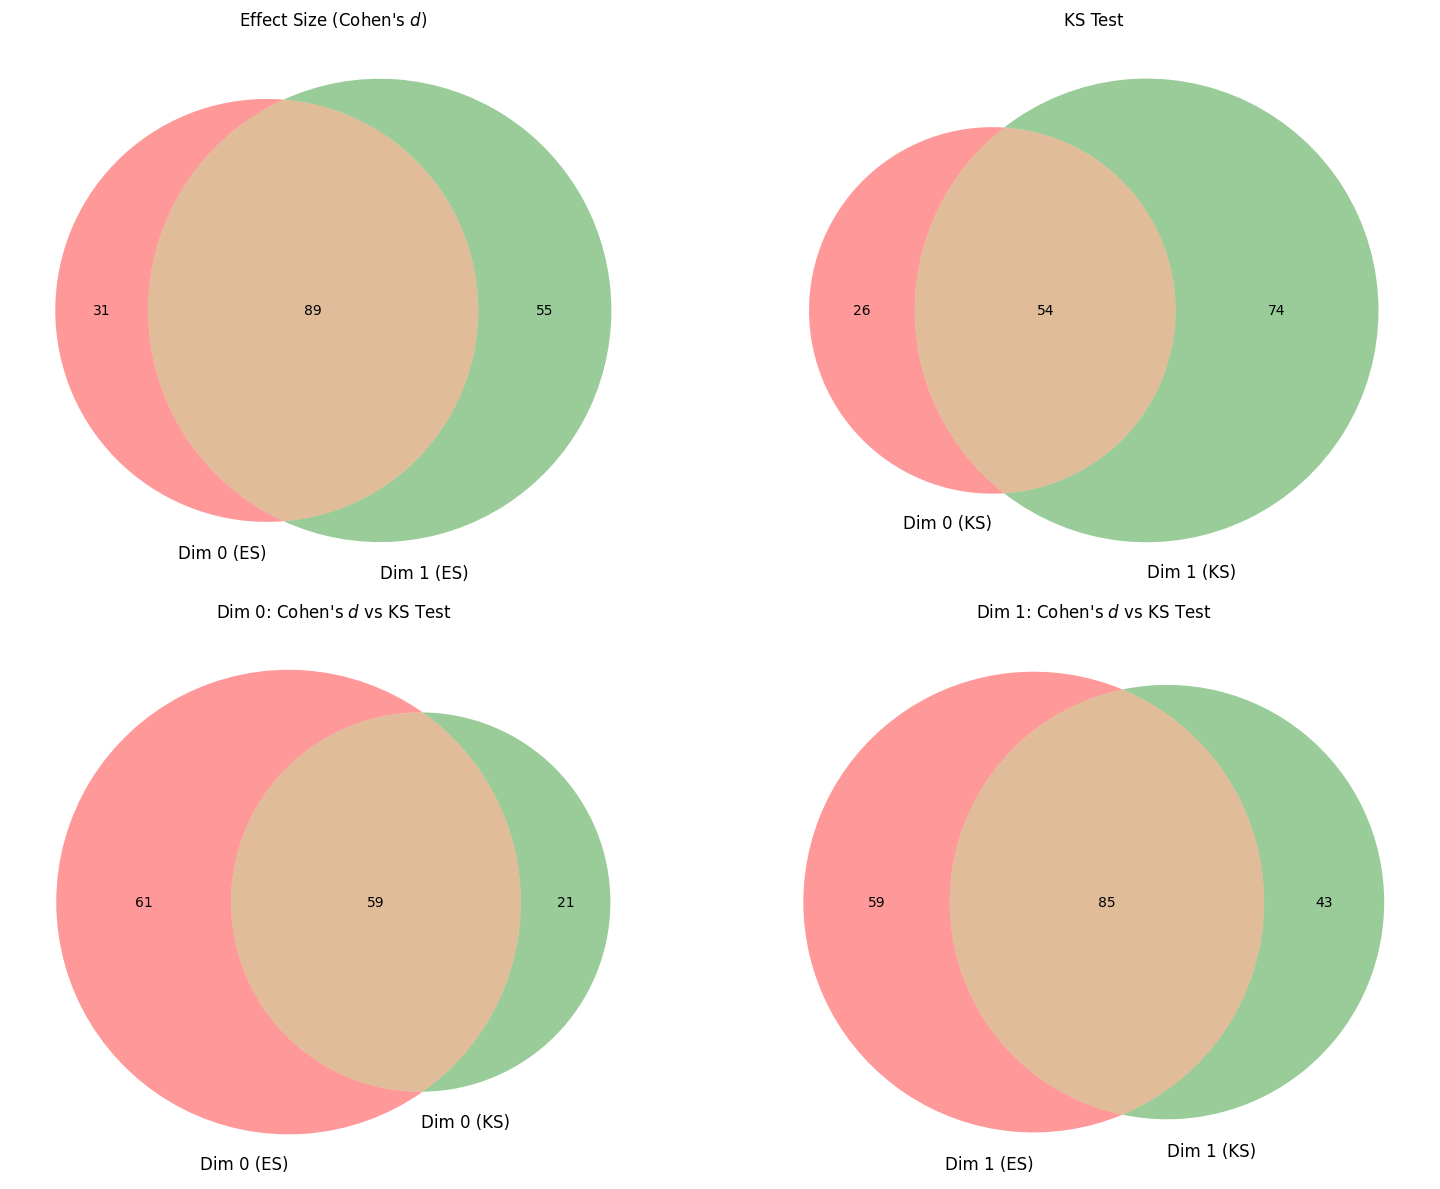

In [131]:
# Define the pathway sets for Cohen's d and KS for Dim 0 and Dim 1
dim0_paths_ess = set(dim0_paths_es)  
dim0_paths_kss = set(dim0_paths_ks)  
dim1_paths_ess = set(dim1_paths_es)  
dim1_paths_kss = set(dim1_paths_ks) 

# Calculate Venn diagram subsets for Cohen's d
dim0_only_es = len(dim0_paths_ess - dim1_paths_ess)
dim1_only_es = len(dim1_paths_ess - dim0_paths_ess)
dim0_dim1_es = len(dim0_paths_ess & dim1_paths_ess)

# Calculate Venn diagram subsets for KS
dim0_only_ks = len(dim0_paths_kss - dim1_paths_kss)
dim1_only_ks = len(dim1_paths_kss - dim0_paths_kss)
dim0_dim1_ks = len(dim0_paths_kss & dim1_paths_kss)

# Calculate relationships between them for Dim 0
dim0_es_not_ks = len(dim0_paths_ess - dim0_paths_kss)
dim0_ks_not_es = len(dim0_paths_kss - dim0_paths_ess)
dim0_both = len(dim0_paths_ess & dim0_paths_kss)

# Calculate relationships between them for Dim 1
dim1_es_not_ks = len(dim1_paths_ess - dim1_paths_kss)
dim1_ks_not_es = len(dim1_paths_kss - dim1_paths_ess)
dim1_both = len(dim1_paths_ess & dim1_paths_kss)

# Create subplots: 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot Cohen'd d Venn diagram
venn_es = venn2(subsets=(dim0_only_es, dim1_only_es, dim0_dim1_es),
                 set_labels=('Dim 0 (ES)', 'Dim 1 (ES)'), ax=axes[0, 0])
axes[0, 0].set_title(f"Effect Size (Cohen\'s $d$)")

# Plot KS Venn diagram
venn_ks = venn2(subsets=(dim0_only_ks, dim1_only_ks, dim0_dim1_ks),
                 set_labels=('Dim 0 (KS)', 'Dim 1 (KS)'), ax=axes[0, 1])
axes[0, 1].set_title("KS Test")

# Plot Absolute vs Direct Correlation Venn diagram for Dim 0
venn_es_ks_0 = venn2(subsets=(dim0_es_not_ks, dim0_ks_not_es, dim0_both),
                       set_labels=('Dim 0 (ES)', 'Dim 0 (KS)'), ax=axes[1, 0])
axes[1, 0].set_title(f"Dim 0: Cohen\'s $d$ vs KS Test")

# Plot Absolute vs Direct Correlation Venn diagram for Dim 1
venn_abs_dir_1 = venn2(subsets=(dim1_es_not_ks, dim1_ks_not_es, dim1_both),
                       set_labels=('Dim 1 (ES)', 'Dim 1 (KS)'), ax=axes[1, 1])
axes[1, 1].set_title(f"Dim 1: Cohen\'s $d$ vs KS Test")

# Adjust layout
plt.tight_layout()

plt.show()